In [205]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

ORANGE_BGR = np.array([  0, 165, 255], dtype=np.float32)  # Netherlands - 1
PURPLE_BGR = np.array([128,   0, 128], dtype=np.float32)  # Belgium     - 0

def binary_mask_50x50_cv2(path):

    # Reads a 50x50 image and returns a mask of {0,1}.
    img = cv2.imread(path, cv2.IMREAD_COLOR)          
    arr = img.astype(np.float32)

    d_orange = np.linalg.norm(arr - ORANGE_BGR, axis=-1)
    d_purple = np.linalg.norm(arr - PURPLE_BGR, axis=-1)

    mask = (d_orange < d_purple).astype(np.uint8)      
    return mask

mask = binary_mask_50x50_cv2("Q1\\border.png")
print(mask.shape, mask.dtype)  # (50, 50) uint8

#print number of 1s in the mask
print("Number of 1s in the mask:", np.sum(mask))  # Number of 1s in the mask: 1250

# Saving the mask as an image
cv2.imwrite("output\\binary_mask_50x50.png", mask * 255)


(50, 50) uint8
Number of 1s in the mask: 1986


True

In [184]:
def make_samples(mask):

    h, w = mask.shape
    samples = []

    for y in range(h):
        for x in range(w):
            samples.append([
                x / (w - 1),
                y / (h - 1),
                float(mask[y, x])
            ])

    samples = np.array(samples, dtype=np.float32)

    np.random.shuffle(samples)


    return samples


In [185]:
samples = make_samples(mask)  # (2500, 3)
print("samples shape:", samples.shape)  
xy = samples[:, :2]
L  = samples[:,  2]
pairs = [ (xy_i, L_i) for xy_i, L_i in zip(xy, L) ]
print("First 5 samples (xy, L):", pairs[:5])


samples shape: (2500, 3)
First 5 samples (xy, L): [(array([0.14285715, 0.1632653 ], dtype=float32), 1.0), (array([0.6122449, 0.6938776], dtype=float32), 0.0), (array([0.20408164, 0.63265306], dtype=float32), 1.0), (array([0.59183675, 0.67346936], dtype=float32), 1.0), (array([0.67346936, 0.48979592], dtype=float32), 1.0)]


mlp_scratch 

  -> __init__.py 

  -> activations.py

  -> layers.py

  -> losses.py

  -> model.py

  -> train.py

  -> utils.py


In [186]:
from mlp_scratch.activations import ReLU, Tanh, Sigmoid, Identity
from mlp_scratch.layers import Linear
from mlp_scratch.model import Model
from mlp_scratch.train import train
from mlp_scratch.utils import binary_accuracy, ensure_dir


In [187]:
def make_xor_dataset():
    X = np.array([[0,0],
                  [0,1],
                  [1,0],
                  [1,1],
                  [0,0],
                  [0,1],
                  [1,0],
                  [1,1]], dtype=np.float32)
    Y = np.array([0, 1, 1, 0, 0, 1, 1, 0], dtype=np.float32)
    return X, Y

X, Y = make_xor_dataset()
X, Y


(array([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.],
        [0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]], dtype=float32),
 array([0., 1., 1., 0., 0., 1., 1., 0.], dtype=float32))

In [188]:
def he_scale(fan_in):
    return float(np.sqrt(2.0 / max(1, fan_in)))

def xavier_scale(fan_in):
    return float(np.sqrt(1.0 / max(1, fan_in)))

def build_relu_model_2_2_1(lr=2e-2, relu_bias=0.1):
    L1 = Linear(2, 4, ReLU(),    scale=he_scale(2))   # ReLU hidden
    L1.b[:] = relu_bias
    L2 = Linear(4, 1, Sigmoid(), scale=xavier_scale(2)) # Sigmoid head
    return Model([L1, L2], loss="bce", lr=lr)

model = build_relu_model_2_2_1(lr=2e-2, relu_bias=0.1)
meta, _ = train(
    model, X, Y,
    batch_size=4,
    grad_accum_steps=1,
    max_epochs=3000,
    patience=300,
    rel_improve_thresh=1e-3,
    runs_dir="runs_xor",
    run_name="xor_relu_trained",
    seed=None,
)

yp = model.predict(X)
print("trained ypred:", yp.ravel())
print("trained acc:", binary_accuracy(yp, Y))


epochs: 100%|██████████| 3000/3000 [00:00<00:00, 5791.86it/s]


trained ypred: [0.15062733 0.89969474 0.93072987 0.08199544 0.15062733 0.89969474
 0.93072987 0.08199544]
trained acc: 1.0


In [ ]:
def grad_check(model, X, Y, eps=1e-5, tol=1e-3):
    
    import numpy as np

    # scalar loss on current params using full batch
    def _loss():
        yp = model.predict(X)
        y = Y[:, None] if Y.ndim == 1 else Y
        return model.loss_fn.forward(yp, y)

    # numerical grads
    num_W, num_b = [], []
    for L in model.layers:
        dW = np.zeros_like(L.W, dtype=np.float32)
        db = np.zeros_like(L.b, dtype=np.float32)
        for idx in np.ndindex(*L.W.shape):
            old = L.W[idx]
            L.W[idx] = old + eps; Lp = _loss()
            L.W[idx] = old - eps; Lm = _loss()
            L.W[idx] = old
            dW[idx] = (Lp - Lm) / (2*eps)
        for j in np.ndindex(*L.b.shape):
            old = L.b[j]
            L.b[j] = old + eps; Lp = _loss()
            L.b[j] = old - eps; Lm = _loss()
            L.b[j] = old
            db[j] = (Lp - Lm) / (2*eps)
        num_W.append(dW); num_b.append(db)

    # backprop grads (one full-batch step)
    for L in model.layers: L.zero_grad()
    model.train_step(X, Y)  # fills L.dW_acc / L.db_acc
    bp_W = [L.dW_acc.copy() for L in model.layers]
    bp_b = [L.db_acc.copy() for L in model.layers]

    # relative error
    def rel_err(a, b):
        import numpy as np
        na, nb = np.linalg.norm(a), np.linalg.norm(b)
        return float(np.linalg.norm(a - b) / max(1e-12, na + nb))

    passed = True
    for i, (nW, nB, aW, aB) in enumerate(zip(num_W, num_b, bp_W, bp_b)):
        eW, eB = rel_err(nW, aW), rel_err(nB, aB)
        print(f"layer {i}: W_err={eW:.3e}  b_err={eB:.3e}")
        passed &= (eW < tol) and (eB < tol)

    return passed


In [190]:
# run once
grad_check(model, X, Y, eps=1e-5, tol=1e-3)

for eps in (1e-4, 1e-5, 1e-6):
    print(f"\n-- eps={eps} --")
    grad_check(model, X, Y, eps=eps, tol=1e-3)


layer 0: W_err=7.768e-01  b_err=7.775e-01
layer 1: W_err=7.776e-01  b_err=7.715e-01

-- eps=0.0001 --
layer 0: W_err=7.780e-01  b_err=7.780e-01
layer 1: W_err=7.773e-01  b_err=7.782e-01

-- eps=1e-05 --
layer 0: W_err=7.768e-01  b_err=7.775e-01
layer 1: W_err=7.776e-01  b_err=7.715e-01

-- eps=1e-06 --
layer 0: W_err=8.040e-01  b_err=8.288e-01
layer 1: W_err=7.265e-01  b_err=5.817e-01


In [191]:
X = xy.astype(np.float32)          # (2500, 2) normalized coords
Y = L.astype(np.float32)           # (2500,)   labels {0,1}
h, w = mask.shape


In [204]:
def he(f): return float(np.sqrt(2.0/max(1,f)))
def xv(f): return float(np.sqrt(1.0/max(1,f)))

def build_model(hidden=(64,64), lr=5e-3, relu_bias=0.1):
    layers = []
    in_dim = 2
    for hsz in hidden:
        L = Linear(in_dim, hsz, Tanh(), scale=he(in_dim))
        L.b[:] = relu_bias
        layers.append(L)
        in_dim = hsz
    layers.append(Linear(in_dim, 1, Tanh(), scale=xv(in_dim)))
    return Model(layers, loss="bce", lr=lr)   # <-- plain BCE

# build model (no BalancedBCELoss)
model = build_model(hidden=(1000,1000), lr=5e-3, relu_bias=0.1)

# optional: good init for the sigmoid head
p = float(mask.mean())
model.layers[-1].b[:] = np.float32(np.log(p/(1.0 - p)))

meta, _ = train(
    model, X, Y,
    batch_size=256,
    grad_accum_steps=2,
    max_epochs=3000,
    patience=100,
    rel_improve_thresh=0.002,
    runs_dir="runs_map",
    run_name="relu_64x2_plain_bce",
    seed=None,
)

# predict full image + metrics
yy, xx = np.meshgrid(np.arange(h), np.arange(w), indexing="ij")
Xfull = np.stack([(xx/(w-1)).astype(np.float32).ravel(),
                  (yy/(h-1)).astype(np.float32).ravel()], axis=1)
pred = model.predict(Xfull).reshape(h, w)
acc  = binary_accuracy(pred.reshape(-1,1), mask.reshape(-1,1).astype(np.float32))
print("map accuracy:", acc)
print("GT prior:", mask.mean(), "Pred prior:", (pred>=0.5).mean())
print("Loss plot:", meta["plot_path"])


epochs:  81%|████████▏ | 2438/3000 [12:44<02:56,  3.19it/s]


map accuracy: 0.7944
GT prior: 0.7944 Pred prior: 1.0
Loss plot: runs_map\relu_64x2_plain_bce\loss_vs_samples.png


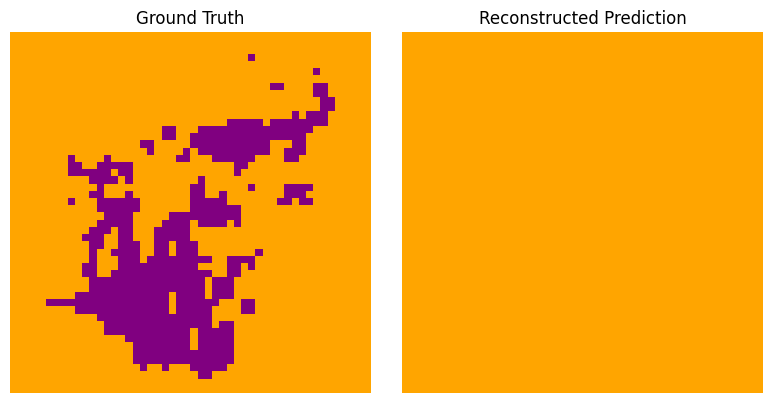

Saved: runs_map\relu_64x2_plain_bce\pred_reconstructed_color.png and runs_map\relu_64x2_plain_bce\gt_color.png


In [197]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Colors (BGR as used by cv2)
ORANGE_BGR = np.array([  0,165,255], dtype=np.uint8)  # class 1
PURPLE_BGR = np.array([128,  0,128], dtype=np.uint8)  # class 0

# 1) Threshold probabilities → binary classes
pred_bin = (pred >= 0.5).astype(np.uint8)            # (h, w) in {0,1}

# 2) Colorize prediction to match the original map’s palette
pred_color = np.zeros((h, w, 3), dtype=np.uint8)
pred_color[pred_bin == 1] = ORANGE_BGR
pred_color[pred_bin == 0] = PURPLE_BGR

# 3) (Optional) Colorize the ground-truth mask too, for side-by-side
gt_color = np.zeros((h, w, 3), dtype=np.uint8)
gt_color[mask == 1] = ORANGE_BGR
gt_color[mask == 0] = PURPLE_BGR

# 4) Save and show
run_dir = meta["run_dir"] if "meta" in globals() else "."
os.makedirs(run_dir, exist_ok=True)
cv2.imwrite(os.path.join(run_dir, "pred_reconstructed_color.png"), pred_color)
cv2.imwrite(os.path.join(run_dir, "gt_color.png"), gt_color)

# display in notebook (matplotlib expects RGB)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(gt_color, cv2.COLOR_BGR2RGB));  plt.title("Ground Truth"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(pred_color, cv2.COLOR_BGR2RGB)); plt.title("Reconstructed Prediction"); plt.axis("off")
plt.tight_layout(); plt.show()

print("Saved:",
      os.path.join(run_dir, "pred_reconstructed_color.png"),
      "and",
      os.path.join(run_dir, "gt_color.png"))


In [194]:
import os

run_dir = meta["run_dir"]; ensure_dir(run_dir)

pred_bin = (pred >= 0.5).astype(np.uint8)
err = (pred_bin != mask).astype(np.uint8)

fig, axs = plt.subplots(1,3, figsize=(9,3))
axs[0].imshow(mask, cmap="gray", vmin=0, vmax=1); axs[0].set_title("Ground truth"); axs[0].axis("off")
axs[1].imshow(pred_bin, cmap="gray", vmin=0, vmax=1); axs[1].set_title("Prediction"); axs[1].axis("off")
axs[2].imshow(mask, cmap="gray", vmin=0, vmax=1)
axs[2].imshow(err, cmap="Reds", alpha=0.6, vmin=0, vmax=1); axs[2].set_title("Errors"); axs[2].axis("off")
plt.tight_layout()
outpath = os.path.join(run_dir, "map_triptych.png")
plt.savefig(outpath, dpi=150); plt.close()
print("saved:", outpath)


saved: runs_map\relu_64x2_plain_bce\map_triptych.png


In [195]:
def try_arch(hidden, lr=5e-3, tag=""):
    m = build_model(hidden=hidden, lr=lr, relu_bias=0.1)
    meta, _ = train(m, X, Y, batch_size=256, grad_accum_steps=2,
                    max_epochs=2000, patience=50, rel_improve_thresh=0.005,
                    runs_dir="runs_map", run_name=f"{tag}_{'-'.join(map(str,hidden))}",
                    seed=None)
    P = m.predict(Xfull).reshape(h,w)
    acc = binary_accuracy(P.reshape(-1,1), mask.reshape(-1,1).astype(np.float32))
    return dict(hidden=hidden, loss=meta["final_epoch_loss"], acc=acc, epochs=meta["epochs_run"], samples=meta["samples_seen"], dir=meta["run_dir"])

# depth sweep @ fixed width=64
depth_results = [try_arch(tuple([64]*d), tag="depth") for d in (1,2,3,4)]
print(depth_results)

# width sweep @ fixed depth=2
width_results = [try_arch((w_,w_), tag="width") for w_ in (16,32,64,128)]
print(width_results)


epochs:   3%|▎         | 51/2000 [00:05<03:11, 10.17it/s]


[{'hidden': (64,), 'loss': 12.80421688079834, 'acc': 0.2056, 'epochs': 51, 'samples': 127500, 'dir': 'runs_map\\depth_64'}, {'hidden': (64, 64), 'loss': 3.2777543937683107, 'acc': 0.7944, 'epochs': 51, 'samples': 127500, 'dir': 'runs_map\\depth_64-64'}, {'hidden': (64, 64, 64), 'loss': 12.804217098999024, 'acc': 0.2056, 'epochs': 51, 'samples': 127500, 'dir': 'runs_map\\depth_64-64-64'}, {'hidden': (64, 64, 64, 64), 'loss': 3.277754390335083, 'acc': 0.7944, 'epochs': 52, 'samples': 130000, 'dir': 'runs_map\\depth_64-64-64-64'}]


epochs:   2%|▎         | 50/2000 [00:02<01:51, 17.55it/s]


[{'hidden': (16, 16), 'loss': 3.2777543952941897, 'acc': 0.7944, 'epochs': 52, 'samples': 130000, 'dir': 'runs_map\\width_16-16'}, {'hidden': (32, 32), 'loss': 3.277754396820068, 'acc': 0.7944, 'epochs': 52, 'samples': 130000, 'dir': 'runs_map\\width_32-32'}, {'hidden': (64, 64), 'loss': 3.2777543899536132, 'acc': 0.7944, 'epochs': 52, 'samples': 130000, 'dir': 'runs_map\\width_64-64'}, {'hidden': (128, 128), 'loss': 12.804216911315917, 'acc': 0.2056, 'epochs': 51, 'samples': 127500, 'dir': 'runs_map\\width_128-128'}]


In [196]:
def run_hparams(bs, ga, lr):
    m = build_model(hidden=(64,64), lr=lr, relu_bias=0.1)
    meta, _ = train(m, X, Y, batch_size=bs, grad_accum_steps=ga,
                    max_epochs=2000, patience=50, rel_improve_thresh=0.005,
                    runs_dir="runs_map", run_name=f"hp_bs{bs}_ga{ga}_lr{lr}",
                    seed=None)
    P = m.predict(Xfull).reshape(h,w)
    acc = binary_accuracy(P.reshape(-1,1), mask.reshape(-1,1).astype(np.float32))
    return dict(bs=bs, ga=ga, lr=lr, acc=acc, loss=meta["final_epoch_loss"],
                epochs=meta["epochs_run"], samples=meta["samples_seen"], time=None, dir=meta["run_dir"])

hp_cfgs = [(128,1,5e-3),(256,2,5e-3),(512,4,5e-3),(256,2,1e-2),(256,2,2e-3)]
hp_results = [run_hparams(*cfg) for cfg in hp_cfgs]
for r in hp_results:
    print(r)


epochs:   3%|▎         | 51/2000 [00:01<01:05, 29.68it/s]


{'bs': 128, 'ga': 1, 'lr': 0.005, 'acc': 0.7944, 'loss': 3.2777543762207033, 'epochs': 51, 'samples': 127500, 'time': None, 'dir': 'runs_map\\hp_bs128_ga1_lr0.005'}
{'bs': 256, 'ga': 2, 'lr': 0.005, 'acc': 0.7944, 'loss': 3.2777544036865236, 'epochs': 53, 'samples': 132500, 'time': None, 'dir': 'runs_map\\hp_bs256_ga2_lr0.005'}
{'bs': 512, 'ga': 4, 'lr': 0.005, 'acc': 0.7944, 'loss': 3.277754373550415, 'epochs': 52, 'samples': 130000, 'time': None, 'dir': 'runs_map\\hp_bs512_ga4_lr0.005'}
{'bs': 256, 'ga': 2, 'lr': 0.01, 'acc': 0.7944, 'loss': 3.2777543952941897, 'epochs': 52, 'samples': 130000, 'time': None, 'dir': 'runs_map\\hp_bs256_ga2_lr0.01'}
{'bs': 256, 'ga': 2, 'lr': 0.002, 'acc': 0.7944, 'loss': 3.2777544162750245, 'epochs': 52, 'samples': 130000, 'time': None, 'dir': 'runs_map\\hp_bs256_ga2_lr0.002'}
